In [15]:
from oggm import cfg, tasks, utils, workflow
from oggm.sandbox import distribute_2d

import geopandas as gpd
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

In [2]:
# Define project name and create output directory
project_name = 'Eyjafjallajokull_ice_cap'
output_dir = utils.mkdir(f'outputs/{project_name}')

### Intro

This workflow was inspired by the OGGM tutorial *"Step-by-Step guide to building preprocessed directories from scratch"* and further enhanced. Nevertheless, this is a helpful resource to better understand the individual process steps.

URL: https://tutorials.oggm.org/stable/notebooks/tutorials/building_the_prepro_gdirs.html

### 1. Find glaciers of interest (RGI IDs)

Starting from a polygon representing the ice cap, the relevant glaciers of the RGI region will be extracted.

In [13]:
path = f'input/{project_name}/glims_polygons.shp'
gdf_ice_cap = gpd.read_file(path)

file = utils.get_rgi_region_file('06', version='62')  # Central Europe
gdf_region = gpd.read_file(file)

filtered_gdf = gdf_region[gdf_region["GLIMSId"].isin(gdf_ice_cap["glac_id"])]

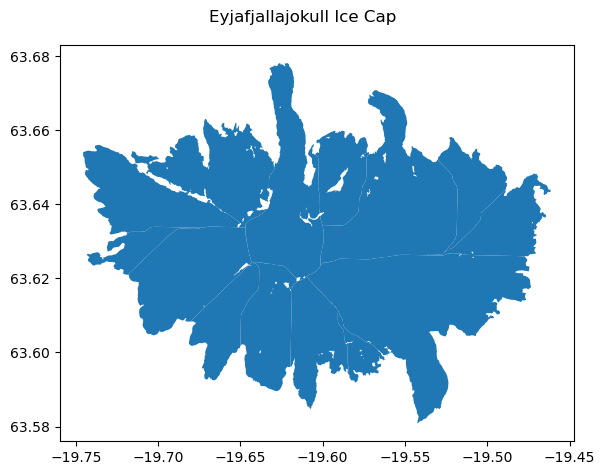

In [17]:
# plot the glaciers of interest
filtered_gdf.plot()
plt.suptitle('Eyjafjallajokull Ice Cap')
plt.tight_layout()
plt.show()

### 2. Initialize working directory

In [4]:
%%capture

# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM-ice_cap', reset=False)
cfg.PARAMS['use_multiprocessing'] = False

# get RGI IDs from previously filtered GeoDataFrame
rgi_ids = filtered_gdf['RGIId'].to_list()
prepro_base_url_L0 = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/elev_bands/'
gdirs = workflow.init_glacier_directories(rgi_ids,
                                          from_prepro_level=0,
                                          prepro_base_url=prepro_base_url_L0,
                                          prepro_border=10,  # could be 10, 80, 160 or 240
                                          reset=True,
                                          force=True,
                                          );

print('Working dir:', cfg.PATHS['working_dir'])

### 3. Use custom DEM for higher spatial resolution (can be skipped if default DEM is fine)

In [5]:
%%capture

# set the method for determining the local grid resolution
cfg.PARAMS['grid_dx_method'] = 'fixed'  # The default method is 'square', which determines the grid spacing (dx) based on the glacier's outline area.
cfg.PARAMS['fixed_dx'] = 10  # This allows setting a specific resolution in meters. It's applicable only when grid_dx_method is set to 'fixed'.
cfg.PARAMS['border'] = 10 # additional space around the glacier outline

custom_dem_path = 'input/Eyjafjallajokull_ice_cap/dem_gee_iceland.tif'
cfg.PATHS['dem_file'] = custom_dem_path

# set the DEM source to use
source = 'USER'

### 4. Create the flowlines surface structure, including surface height and width (Level 2).

In [6]:
# this task adds the DEM and defines the local grid
workflow.execute_entity_task(tasks.define_glacier_region, gdirs, source=source)

elevation_band_task_list = [
    tasks.simple_glacier_masks,
    tasks.elevation_band_flowline,
    tasks.fixed_dx_elevation_band_flowline,
    tasks.compute_downstream_line,
    tasks.compute_downstream_bedshape,
]

for task in elevation_band_task_list:
    workflow.execute_entity_task(task, gdirs)

### 5. Add baseline climate data to gdir, calibrate mass balance and conduct an inversion for the glacier’s bed topography (Level 3)

In [7]:
%%capture

# define the climate data to use, we keep the default
cfg.PARAMS['baseline_climate'] = cfg.PARAMS['baseline_climate']

# add climate data to gdir
workflow.execute_entity_task(tasks.process_climate_data, gdirs)

# the default mb calibration
workflow.execute_entity_task(tasks.mb_calibration_from_geodetic_mb,
                             gdirs,
                             informed_threestep=True,  # only available for 'GSWP3_W5E5'
                            );

# glacier bed inversion
workflow.execute_entity_task(tasks.apparent_mb_from_any_mb, gdirs);
workflow.calibrate_inversion_from_consensus(
    gdirs,
    apply_fs_on_mismatch=True,
    error_on_mismatch=True,  # if you running many glaciers some might not work
    filter_inversion_output=True,  # this partly filters the overdeepening due to
    # the equilibrium assumption for retreating glaciers (see. Figure 5 of Maussion et al. 2019)
    volume_m3_reference=None,  # here you could provide your own total volume estimate in m3
)

# finally create the dynamic flowlines
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)

### 6. Define the baseline climate adjust calibration parameters if needed

In [8]:
%%capture

# define the baseline climate and add it
cfg.PARAMS['baseline_climate'] = 'ERA5'
workflow.execute_entity_task(tasks.process_climate_data, gdirs);

# define the default precipitation factor
cfg.PARAMS['prcp_fac'] = 1.6  # Note: This is not a universial value!
cfg.PARAMS['use_winter_prcp_fac'] = False  # This option is only available for 'GSWP3_W5E5'
cfg.PARAMS['use_temp_bias_from_file'] = False  # This option is only available for 'GSWP3_W5E5'

# an example of static calibration for mass balance, more options are available in the tutorial
workflow.execute_entity_task(tasks.mb_calibration_from_geodetic_mb,
                             gdirs,
                             overwrite_gdir=True,
                             calibrate_param1='melt_f',
                             calibrate_param2='prcp_fac',
                             calibrate_param3='temp_bias')

### 7. Initialize the current glacier state with a dynamic spinup (Level 4)

In [9]:
%%capture

# add additional outputs to default OGGM
cfg.PARAMS['store_model_geometry'] = True
cfg.PARAMS['store_fl_diagnostics'] = True
cfg.PARAMS['evolution_model'] = 'SemiImplicit'
# cfg.PARAMS['evolution_model'] = 'FluxBased'
cfg.PARAMS['use_multiprocessing'] = False

# get the start and end year of the selected baseline
y0 = gdirs[0].get_climate_info()['baseline_yr_0']
ye = gdirs[0].get_climate_info()['baseline_yr_1'] + 1  # run really to the end until 1.1.

# 'static' initialisation
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                             min_ys=y0, ye=ye,
                             fixed_geometry_spinup_yr=None,  # here you could add a static spinup if you want
                             output_filesuffix='_historical')

# 'dynamic' initialisation, including dynamic mb calibration
dynamic_spinup_start_year = 1979
minimise_for = 'area'  # other option would be 'volume'
workflow.execute_entity_task(
    tasks.run_dynamic_melt_f_calibration, gdirs,
    err_dmdtda_scaling_factor=0.2,  # by default we reduce the mass balance error for accounting for
    # corrleated uncertainties on a regional scale
    ys=dynamic_spinup_start_year, ye=ye,
    kwargs_run_function={'minimise_for': minimise_for},
    ignore_errors=True,
    kwargs_fallback_function={'minimise_for': minimise_for},
    output_filesuffix='_spinup_historical',
)

### 8. Run random climate

See the following OGGM tutorial for reference: https://tutorials.oggm.org/stable/notebooks/tutorials/distribute_flowline.html

In [10]:
%%capture

cfg.PARAMS['use_multiprocessing'] = True

# Do a random run with a bit of warming
workflow.execute_entity_task(
    tasks.run_random_climate,
    gdirs,
    ys=2020, ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
    y0=2009, halfsize=10,  # Random climate of 1999-2019
    seed=1,  # Random number generator seed
    temperature_bias=0.5,  # additional warming - change for other scenarios
    store_fl_diagnostics=True,  # important! This will be needed for the redistribution
    init_model_filesuffix='_spinup_historical',  # start from the spinup run
    output_filesuffix='_s05',  # optional - here I just want to make things explicit as to which run we are using afterwards
)

# This is to add a new topography to the file (smoothed differently)
workflow.execute_entity_task(distribute_2d.add_smoothed_glacier_topo, gdirs)
# This is to get the bed map at the start of the simulation
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
workflow.execute_entity_task(distribute_2d.assign_points_to_band, gdirs)

ds = workflow.execute_entity_task(
    distribute_2d.distribute_thickness_from_simulation,
    gdirs,
    input_filesuffix='_s05',  # Use the simulation we just did
    concat_input_filesuffix='_spinup_historical',  # Concatenate with the historical spinup
    output_filesuffix='_10m_s05',  # filesuffix added to the output filename gridded_simulation.nc, if empty input_filesuffix is used
)

### 9. Merge redistributed thickness from multiple glaciers

**Note**: output files are generated for every 10 years. Yearly output can be generated but requires more processing time: `np.arange(1979, 2101, 1)`

In [11]:
cfg.PARAMS['use_multiprocessing'] = True

simulation_filesuffix = '_10m_s05'  # saved in variable for later opening of the files
distribute_2d.merge_simulated_thickness(
    gdirs,  # the gdirs we want to merge
    simulation_filesuffix=simulation_filesuffix,  # the name of the simulation
    years_to_merge=np.arange(1979, 2101, 10),  # for demonstration I only pick some years, if this is None all years are merged
    add_topography=False,  # if you do not need topogrpahy setting this to False will decrease computing time
    preserve_totals=True,  # preserve individual glacier volumes during merging
    reset=True,
)

files_to_open = glob.glob(
    os.path.join(
        cfg.PATHS['working_dir'],  # the default output_folder
        f'gridded_simulation_merged{simulation_filesuffix}*.nc',  # with the * we open all files which matches the pattern
    )
)

print('Files to merge:', len(files_to_open))
with xr.open_mfdataset(files_to_open) as ds_merged:
    ds_merged = ds_merged.load()

ds_merged.to_netcdf(output_dir + f"/merged_iceland{simulation_filesuffix}.nc")
print('File saved at:', output_dir + f"/merged_iceland{simulation_filesuffix}.nc")

Files to merge: 14
File saved at: outputs/Eyjafjallajokull_ice_cap/merged_iceland_10m_s05.nc


### 10. Merging the `gridded_data` files of multiple glacier directories (e.g. for topography)

In [12]:
ds_merged = workflow.merge_gridded_data(
    gdirs,
    output_folder=None,  # by default the final file is saved at cfg.PATHS['working_dir']
    output_filename='gridded_data_merged',  # the default file is saved as gridded_data_merged.nc
    use_glacier_mask=True,
    included_variables='all',  # you also can provide a list of variables here
    add_topography=True,  # here we can add topography for the new extend
    reset=True,  # set to True if you want to overwrite an already existing file (for playing around)
)

ds_merged.to_netcdf(output_dir + f"/merged_iceland_gridded.nc")
print('File saved at:', output_dir + f"/merged_iceland_gridded.nc")

File saved at: outputs/Eyjafjallajokull_ice_cap/merged_iceland_gridded.nc
